# 447 21fa exam 2 due 5p Fri Dec 10

***You are welcome (and encouraged) to:***
- use analytical and numerical computational tools -- specify the tool(s) in sourcecode and/or text;
- reuse example sourcecode and other materials provided in this course;
- consult textbooks, websites, and other publicly-available materials -- include full citation(s) with the URL and/or [DOI](https://en.wikipedia.org/wiki/Digital_object_identifier).

***You are not permitted to discuss the exam problems or share any part of your solutions with anyone other than the Professor or TA for this course.***
- By submitting your exam solution on Canvas, you are affirming your understanding of and adherence to these restrictions.
- We will answer questions during the class Zoom meetings Mon Dec 6 and Wed Dec 8.
- We will also answer questions posted to the Canvas Discussion board until 5p Fri Dec 10.

***The exam deadline is 5p Fri Dec 10 on Canvas.***
- Final submissions received before this deadline will receive +1 bonus points.
- Everyone automatically receives a deadline extension to 11:59p Sun Dec 12. ***No further deadline extensions will be granted -- please plan accordingly.***

In [1]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


In [2]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# render animation
mpl.rc('animation',html='html5')
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


In [3]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [4]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

Colaboratory Notebook


In [5]:
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install control
  !pip install JSAnimation
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')
    

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

     |████████████████████████████████| 339 kB 15.3 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=af2e4e7dd866358d3c818710e682a1030d466969f7304c1fe5d8d94968ab5a9a
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11425 sha256=892d5a1ad37ccb4f4bc0bdddf2b7a0ab19a03abd48eb436ea87516942a66ff6d
  Stored in directory: /root/.cache/pip/wheels/0e/4e/3d/05fb8cca2646ee0bbfbce17c40a970f48d5e0698b9e5aaa91f
Successfully built JSAnimation


In [6]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# problem (1.)

Consider the following block diagram:

![block diagram](https://docs.google.com/drawings/d/e/2PACX-1vSrZYQ4nqWsHqgbqBAVMvo3TIwHwhmyB9VR-ve-vz36AkVQRV6v5PAREjXxqDURsiADKVTVprm7p2Y7/pub?w=321&h=138)

## subproblem (1a.)

If $A = P^{-1}$ and you are free to design $B$, is there a tradeoff between performance of reference-tracking (where we want $G_{yr} \approx 1$) and performance of disturbance-rejection (where we want $G_{yd} \approx 0$)?

**Possible Solution #1:**

Let's say $d$ is my input disturbance, and I also have $w$, which is my output disturbance in between $P$ and $y$.

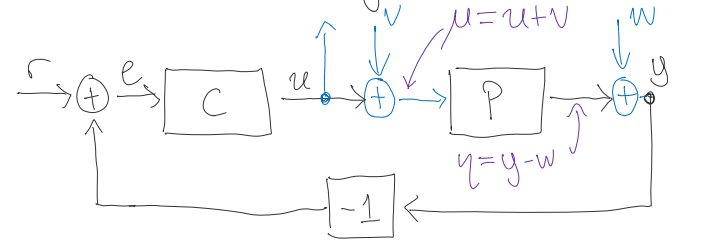

$d = v$

$u = \frac{C}{1+PC}r-\frac{PC}{1+PC}v-\frac{C}{1+PC}w$

$= G_{ur}r+G_{uv}v+G_{uw}w$

$y = G_{yr}r + G_{yv}v + G_{yw}w$

$  = \frac{PC}{1+PC}r + \frac{P}{1+PC}v + \frac{1}{1+PC}w$

Ideally, I want to have..

$G_{yw}+G_{yv} = \frac{1}{1+PC}+\frac{PC}{1+PC} = \frac{1+PC}{1+PC} = 1$

$G_{yw}, G_{uv} \approx 0$

**Thus, it is not possible to satisfy the two requirements simultaneously**
 
At any particular frequency, I can either choose to focus on rejecting the effect that output disturbance w has an output $y$ or we can choose to reject the effect that input disturbance $d$ has an input $u$. This is because one attenuates(rejects) input or output disturbance, the other just passes through.  

If we look at the bode plots, 

$log|s(jw)| < 0$, $|s(jw)| < 1$ $\leftrightarrow$ disturbance attenuated 

Any range of frequencies where the controller attenuates disturbance is compensated by the range where the controller causes amplificiation on disturbance(make things worse). 

**Possible Solution: #2**

However, in this block diagram, $G_{yr} = \frac{P(A+B)}{1 + P B} r$ 
Therefore, 

$$\frac{PA + PB}{1 + PB}$$

$$A = \frac{1}{P}$$

$$\frac{P\frac{1}{P} + PB}{1 + PB}$$

$$\frac{1+PB}{1+PB} \approx 1$$

However,

$$y_d = \frac{P}{1 + P B} d $$

$$=\frac{P}{1+ P B}$$

$$ u = A r + B(r-y) = (A + B)r - BP(u+d). $$

$$ u = \frac{A + B}{1 + B P} r - \frac{B P}{1 + B P} d = G_{ur} r + G_{ud} d. $$

$$y = \frac{P(A+B)}{1 + P B} r + \frac{P}{1 + P B} d $$.

**Therefore, for this diagram, there is no trade-off.**

## subproblem (1b.)

Suppose the process transfer function $P$ has a zero in the right half-plane, that is, there exists $z\in\mathbb{C}$ such that $\operatorname{Re} z > 0$ and $P(z) = 0$.  

Explain why implementing $A = P^{-1}$ would be a bad idea.

$P(s) = \frac{b(s)}{a(s)}$, where $a(s)$ and $b(s)$ are polynomial formulas and (e.g. $b(s) = s-1$.)

"$P$ has a zero in the right half-plane." This means the root of $b(s)$ has a positive value(in the right half-plane,) meaning the system is unstable.

*$n$ is a number of poles and $m$ is a number of zeros.*

$P(s) = \frac{b(s)}{a(s)}=\frac{b_os^m+b_1s^{m-1}+\cdot \cdot \cdot+b_m}{s^n+a_1s^{n-1}+\cdot \cdot \cdot+a_n}$

$\frac{PC}{1+PC} = \frac{k\frac{b}{a}}{1+k\frac{b}{a}}\frac{a}{a}=\frac{kb(s)}{a(s)+kb(s)}$

As k, $|s|\rightarrow \infty$, the closed-loop poles converge to zero of $P$ or $(n-m)th$ "roots of unity." With a proportional controller, when $n-m = 2$, the pole(s) go up and down in the graph. However, when $n-m = 3$ or $4$, some poles go past in the right hand-plane, meaning that the system becomes unstable.

**However, the transfer function of this diagram has $1+PB$ in the numerator. So, $A=P^{-1}$ does not give any impact(no control) on $1+PB.$**

$$y = \frac{P(A+B)}{1 + P B} r + \frac{P}{1 + P B} d $$.

Thus, I don't think it can control and stabilize it.

If anything, because of this term, $A=P^{-1}$, the one zero will go down in the numerator and become a pole in the right hand plane, which means it becomes unstable.

# problem (2.)

Consider application of proportional feedback $C(s) = k_P$ in the standard negative feedback loop to the following process model:

$$ P(s) = \frac{s-1}{a(s)}. $$

## subproblem (2a.)

Suppose the closed-loop system can be stabilized by proportional feedback.  Explain why the controller gain $k_P$ cannot be too large.

$$\frac{P(s)C(s)}{1+P(s)C(s)} = \frac{\frac{(s-1)k_p}{a(s)}}{1+\frac{(s-1)k_p}{a(s)}}$$

$$\lim_{S\to\infty} P(s) = 1+\frac{-K}{1+K} = \frac{1+K}{1+K} + \frac{-K}{1+K} = \frac{1}{1+K}$$ 

One particular example I would like to give is,

**Please scroll down for a root locus diagram, "#Solution for 2 a"**

My goal is to make this transfer function as close to $1$ as possible. However, no matter how large I make $k_p$, there is always going to be a slight difference between the transfer function and 1. If I increased $k_p$ too aggressive, it would generate jerky behaviors, and sometime it can drive the system unstable.
The controller gain $k_p$ cannot be too large because it gives an output to the actuator that is porportional to the error. P control systems heavily rely on actuators, and these actuators have output limits (They saturate.) In second-order systems, if K is too large, that means its going to be under-damped. 

## subproblem (2b.)

Create the root-locus diagram for the closed-loop system when $a(s) = s^2 + s + 2$, and determine the upper bound on $k_P$ that ensures the closed-loop system is stable. 

**Solution:**

If k_P is greater or equal to 2, the closed-loop system becomes unstable.

**Please scroll down for the solution.**

## subproblem (2c.)

Can you apply the Nyquist stability criterion from lecture to assess stability of the controlled system when $a(s) = s^2 - 1$?  Explain why or why not.

$$L(s) = P(s)C(s) = \frac{s-1}{s^2-1}k_p$$

$$L(s) = P(s)C(s) = \frac{1}{s+1}k_p$$

$$s = -1$$

As shown below in root locus for 2d, L has one pole $(s = -1)$, which is also my bad point, only in the left-hand side meaning that it is stable. If L has no poles in the right-hand plane, then we can tell the closed-loop system $\frac{L}{1+L}$ is stable, and there must not be any pole in the right-hand side. Therefore, the Nyquist stability criterion can be used for this system to verify stability.


## subproblem (2d.)

Can the system be stabilized with proportional feedback when $a(s) = s^2 - 1$?

$$L(s) = P(s)C(s)$$

$$P(s) = \frac{s-1}{s^2-1}$$

$$C(s) = k_P$$

$$=\frac{(s-1)k_P}{(s-1)(s+1)}$$

$$=\frac{k_P}{(s+1)}$$

For the closed-loop system,

$$\frac{P(s)C(s)}{1+P(s)C(s)}$$

$$= \frac{\frac{k_P}{(s+1)}}{1+\frac{k_P}{(s+1)}}$$

$$=\frac{\frac{k_P}{s+1}}{\frac{s+1+k_P}{s+1}}$$

$$=\frac{k_P}{s+(1+k_P)}$$

As we can see in the equation, I have the control of the constant number in the denominator($1+k_P$). So, I can control this system.


Also, if I plug this equation into my root locus program shown all the way down below (#solution for 2 d),

**Note: Please scroll down for root locus diagram.**
$$$$
$$$$
**Yes, this system can be stabilized with proportional feedback as shown below in root locus diagram.**

**P.S. Isn't the system already stable? why would we want to stabilize a stable system?**

k_P*(s - 1)/(s*(s + 2)*(s**2 + 2*s + 4))
k_P*(s - 1)/(k_P*(s - 1) + s*(s + 2)*(s**2 + 2*s + 4))
[1.]


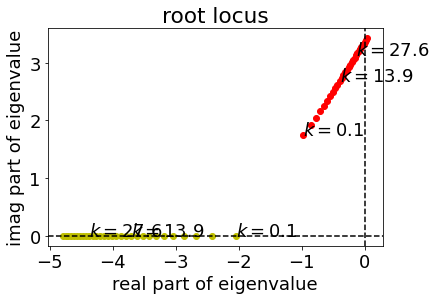

In [66]:
# Solution for 2 a.
sym.var('s',complex=True) # equivalent to s = sym.symbols('s')
sym.var('k_P', positive=True)
P = (s-1) / (s*(s+2)*(s**2+(2*s)+4))
C = k_P
PC = P*C
print(PC)

G = (P*C) / (1 + (P * C))

G = sym.simplify(G)
print(G)
K_ = np.linspace(0.1,40,30) #As K increases, the system becomes unstable as shown in the root locus.
lambda1 = np.array([])
lambda2 = np.array([])
#lambda3 = np.array([])

for k in K_ :
  num = [k, -k]
  deno = [1, 4, 8, 8+k,-k] #((s-1)kp) / (s(s+2)(s^2s+4)+skp-kp)
  tf = ctrl.TransferFunction(num,deno)
  ss = ctrl.tf2ss(tf)
  
  eigenvalue, _ = np.linalg.eig(ss.A)
  #print(eigenvalue)
  lambda1 = np.append(lambda1, eigenvalue[0])
  lambda2 = np.append(lambda2, eigenvalue[1])
  #lambda3 = np.append(lambda3, eigenvalue[2])
print(ctrl.zero(tf))
assert np.allclose(lambda1[np.abs(lambda1.imag) > 0.],
                   np.conj(lambda2[np.abs(lambda1.imag) > 0]))

plt.title('root locus')
plt.xlabel('real part of eigenvalue')
plt.ylabel('imag part of eigenvalue')
plt.scatter(lambda1.real, lambda1.imag, color='y')
plt.scatter(lambda2.real, lambda2.imag, color='r')
#plt.scatter(lambda3.real, lambda3.imag, color='g')
for k,lam1,lam2 in list(zip(K_,lambda1,lambda2))[::10]:
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam1.real,lam1.imag))
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam2.real,lam2.imag))
#x- and y- limits and drawing axes
ylim = plt.ylim()
plt.plot(np.zeros(2),ylim,'k--')
xlim = plt.xlim()
plt.plot(xlim,np.zeros(2),'k--')
plt.xlim(xlim); plt.ylim(ylim);


 2 s - 2
---------
s^2 + 3 s



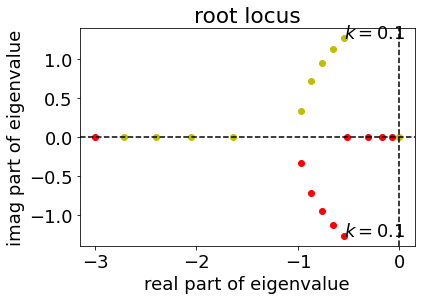

In [61]:
# Solution for 2 b.

K_ = np.linspace(0.1,2,10) # when k = 2, the system becomes unstable.
                           # Therefore, k should be lower than 2.
lambda1 = np.array([])
lambda2 = np.array([])
#lambda3 = np.array([])

for k in K_ :
  num = [k, -k]
  deno = [1,1+k,-k+2] # skp-1kp / s^2+skp+s+(-kp+2)
  tf = ctrl.TransferFunction(num,deno)
  ss = ctrl.tf2ss(tf)


  
  #print(ss)
  eigenvalue, _ = np.linalg.eig(ss.A)
  #print(eigenvalue)
  lambda1 = np.append(lambda1, eigenvalue[0])
  lambda2 = np.append(lambda2, eigenvalue[1])
  #lambda3 = np.append(lambda3, eigenvalue[2])
print(tf)
assert np.allclose(lambda1[np.abs(lambda1.imag) > 0.],
                   np.conj(lambda2[np.abs(lambda1.imag) > 0]))

plt.title('root locus')
plt.xlabel('real part of eigenvalue')
plt.ylabel('imag part of eigenvalue')
plt.scatter(lambda1.real, lambda1.imag, color='y')
plt.scatter(lambda2.real, lambda2.imag, color='r')
#plt.scatter(lambda3.real, lambda3.imag, color='g')
for k,lam1,lam2 in list(zip(K_,lambda1,lambda2))[::10]:
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam1.real,lam1.imag))
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam2.real,lam2.imag))
#x- and y- limits and drawing axes
ylim = plt.ylim()
plt.plot(np.zeros(2),ylim,'k--')
xlim = plt.xlim()
plt.plot(xlim,np.zeros(2),'k--')
plt.xlim(xlim); plt.ylim(ylim);

[ 0. -3.]


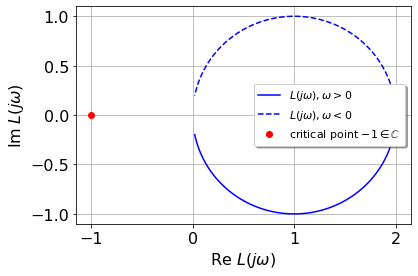

In [64]:
#Solution for 2 C.

k_p = 2
L = lambda s,a=1 : (k_p) / (s+1)
#k_p = 1
#print(L)
# equivalently:

def L(s,a=1):
  return (k_p) / (s+1)
#ctrl.pole(ss)
omega = np.linspace(0.,1e1,1000)

Omega = L(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=11,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

[-1.1]
[-1.441]
[-1.783]
[-2.124]
[-2.466]
[-2.807]
[-3.148]
[-3.49]
[-3.831]
[-4.172]
[-4.514]
[-4.855]
[-5.197]
[-5.538]
[-5.879]
[-6.221]
[-6.562]
[-6.903]
[-7.245]
[-7.586]
[-7.928]
[-8.269]
[-8.61]
[-8.952]
[-9.293]
[-9.634]
[-9.976]
[-10.317]
[-10.659]
[-11.]


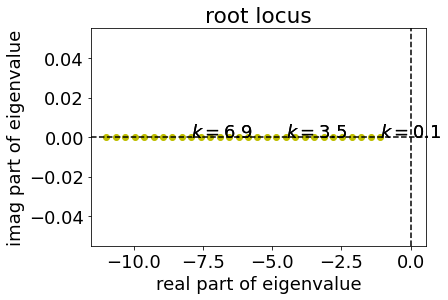

In [ ]:
#Solution for 2 d.

K_ = np.linspace(0.1,10,30) #proportional controller from 0.1 to 10

lambda1 = np.array([])
lambda2 = np.array([])
lambda3 = np.array([])

for k in K_ :
  num = [k]
  deno = [1,1+k] 
  tf = ctrl.TransferFunction(num,deno)  # k_p / (s + (1+k_P))
  ss = ctrl.tf2ss(tf)

  #print(tf)

  eigenvalue, _ = np.linalg.eig(ss.A)
  print(eigenvalue)
  lambda1 = np.append(lambda1, eigenvalue[0])
  lambda2 = np.append(lambda2, eigenvalue[0])
  #lambda3 = np.append(lambda3, eigenvalue[2])

assert np.allclose(lambda1[np.abs(lambda1.imag) > 0.],
                   np.conj(lambda2[np.abs(lambda1.imag) > 0]))

plt.title('root locus')
plt.xlabel('real part of eigenvalue')
plt.ylabel('imag part of eigenvalue')
plt.scatter(lambda1.real, lambda1.imag, color='y')
#plt.scatter(lambda2.real, lambda2.imag, color='r')
#plt.scatter(lambda3.real, lambda3.imag, color='g')
for k,lam1,lam2 in list(zip(K_,lambda1,lambda2))[::10]:
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam1.real,lam1.imag))
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam2.real,lam2.imag))
#x- and y- limits and drawing axes
ylim = plt.ylim()
plt.plot(np.zeros(2),ylim,'k--')
xlim = plt.xlim()
plt.plot(xlim,np.zeros(2),'k--')
plt.xlim(xlim); plt.ylim(ylim);

# problem (3.)
Consider the following ***Bode plots*** of ***process*** $P(s)$ and ***controller*** $C(s)$ transfer functions -- note that applying the ***Nyquist stability criterion*** to the open-loop transfer function $L(s) = P(s) C(s)$ shows that the closed-loop system is stable.

![](http://faculty.washington.edu/sburden/447/447-19fa-bode-PC.png)

Suppose there is error in the measurement of the process model, so that the magnitude of the actual system's process transfer function could be off by as much as a factor of 10 (i.e. as small as $10\%$ or as large as $1,000\%$ of the value for $|P|$ graphed above).

How would you modify $C$ to ensure the closed-loop system is stable for any process transfer function within these error bounds?

**Solution:**

$db = 20 \log_{10} M_G$

The gain margin of this graph is approximately $10^{-2} = 40db$ at the point where the blue line hits $-180^\circ$ in the bottom graph. If we look at the unity transfer function, which is,

$$T(s) = \frac{L(s)}{1+L(s)}$$

If L(s) in the denominator gets to -1, meaning that the $G_M$ becomes greater than 1, that means this system becomes unstable(*not bounded input bounded output stable anymore.*) Going back to the question, it says "1000% large", this means the magnitude becomes $10^1 = 20 db$, which is out of the gain margin and the system becomes unstable.

$$L(s) = 10^1P(s)C(s)$$

In order to fix this problem, I would use a proportional controller to decrease the magnitude by multiplying 0.1. I also believe I don't have to consider the case where the error is as small as 10% because $10^{-1} = 20db$ is still within my gain margin, so I can say it is still stable.  

$$C(s) = 0.1C(s)$$

$$L(s) = 10^1P(s)C(s)$$ 

$$L(s) = P(s)C(s)$$

Then, the system becomes stable.

**Please check out the bode plots below**

In [30]:
import control

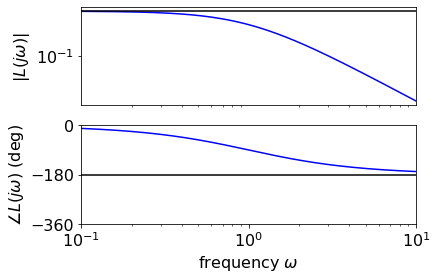

In [94]:
#solution for 3
m = 1
c = 2
k = 1
error = 10**1
k_P = 0.1 # proportional controller that stabilizes the system.
L = lambda s : (error / ((m*s**2)+(c*s)+k))*k_P

#num = [1]
#den = [m, c, k]
#tf = ctrl.TransferFunction(num,den)
#print(tf)
#gm, pm, Wcg, Wcp = control.margin(tf)
#print(gm)
#print(pm)

omega = np.logspace(-1,1,1000)
xlim = omega[[0,-1]]

abs_L = np.abs(L(1.j*omega))
angle_L = np.unwrap(np.angle(L(1.j*omega)))*180./np.pi

critical = (angle_L < -180).nonzero()[0]

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid('on')
ax.loglog(omega,abs_L,'b-')
ax.loglog(xlim,[1.,1.],'k-')
ax.loglog(omega[critical],abs_L[critical],'ro')
ax.set_ylabel(r'$|L(j\omega)|$')
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)
ax.grid()

ax = plt.subplot(2,1,2); ax.grid('on')
ax.semilogx(omega,angle_L,'b-')
ax.semilogx(xlim,[-180.,-180.],'k-')
ax.semilogx(omega[critical],angle_L[critical],'ro')
ax.set_xlabel(r'frequency $\omega$')
ax.set_ylabel(r'$\angle L(j\omega)$ (deg)')
ax.set_yticks([0,-180,-360])
ax.set_xlim(xlim)
axs.append(ax)
ax.grid()

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

# problem (4.)

You just started a new job as a ***Senior Control System Engineer*** at a startup company that is creating autonomous vehicles.  Your first task in this new role is to lead the design of the *cruise control* subsystem.

You decide to use the following first-order process model for the relationship between the vehicle's throttle $\tau$ and velocity $v$: 

$$\dot{v} = -\alpha v + \beta \tau,$$

where $\alpha > 0$ is the coefficient of aerodynamic drag and $\beta > 0$ is the transmission gear ratio.  Your controller can directly measure velocity $v$.

## subproblem (a.)

Design a controller that will make the velocity $v$ converge to a desired speed $r > 0$.

$$\dot{v} = -\alpha v + \beta \tau$$

$$r = input$$ 

$$y = output$$ 

$$y = \alpha v$$

$$\beta \tau = k_p(r-y)+k_I\int(r-y)\,dt $$

$$\tau = \frac{k_p}{\beta}(r-y)+\frac{k_I}{\beta}\int(r-y)\,dt $$

$$ z = \int(r-y)\,dt$$

$$ z = \int(r-\alpha v)\,dt$$

$$\dot{z} = r - \alpha v$$

$$\tau = \frac{k_p}{\beta}(r-\alpha v)+\frac{k_I}{\beta}z$$

$$\dot{v} = -\alpha v - \frac{k_p}{\beta}\alpha v + \frac{k_I}{\beta}z + \frac{k_p}{\beta}r$$

$$\frac{d}{dt}\left[\begin{matrix} \dot{v} \\ \dot{z} \end{matrix}\right] = \left[\begin{matrix} -\alpha-\frac{k_p}{\beta}\alpha & \frac{k_I}{\beta}\\ -\alpha & 0 \end{matrix}\right] \left[\begin{matrix} v \\ z \end{matrix}\right] + \left[\begin{matrix} \frac{k_p}{\beta} \\ 1 \end{matrix}\right]r$$

$$y = \left[\begin{matrix} \alpha && 0 \end{matrix}\right] \left[\begin{matrix} v \\ z \end{matrix}\right]$$

## subproblem (b.)

Implement your controller from (a.) with $\alpha, \beta = 1$, provide a plot showing the velocity $v$ converging to the desired speed $r$, and compute the gain and phase margins $g_m$, $\varphi_m$ for the controlled system.

**Please scroll down for possible solution #1 and #2**


## subproblem (c.)

You learned from a meeting with the mechatronics team that your model for the vehicle was overly simplistic -- in particular, the torque applied by the transmission changes with speed,

$$\dot{v} = -\alpha v + \gamma(v) \tau,$$

where $\gamma:\mathbb{R}\rightarrow\mathbb{R}$ is a smooth positive function that the mechatronics team can determine from their computer-aided design (CAD) program.  Explain how you would redesign your controller for a given $\gamma$.  Can you still ensure the velocity $v$ will converge to a desired speed $r > 0$?

**Possible Solution #1**

I would come up with a new state-space model, including $\ddot{v}$ and $\ddot{z}$ (4x1 vector), and then to my new $Bu$, I would feed a PI controller and check out if the system becomes stable with this controller or not.

**Possible Solution #2**

If the approach with the same controller written above does not work and cannot stabilize the system, I would attempt to stabilize the system with a PID controller. The reason for that is that "D" controller is the derivative controller with an anticipative ability by using a prediction of the error. $e(t+T_{d}) \approx e(t)+T_{d}\frac{de(t)}{dt}$, which predicts the error, $T_{d}$ time units ahead. This control action is thus a sum of three terms: the past as represented by the integral of the error, the present as represented by the proportional term and the future as represented by a linear extrapolation of the error (the derivative term). Therefore, I believe I would be able to stabilize the system.
$$$$
$$$$
*Source Cited*

Feedback Systems by Karl Johan Aström ˚ Richard M. Murray

In [ ]:
!pip install control

     |████████████████████████████████| 339 kB 5.1 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=f699abdc14a15105f7006b79c0ca1dd53b7b606bda8e053bbcfb81c72ce5a686
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control



    s + 2
-------------
s^2 + 2 s + 2

(inf, 143.13010235415567, nan, 1.0000000000000062)


Text(0, 0.5, 'input')

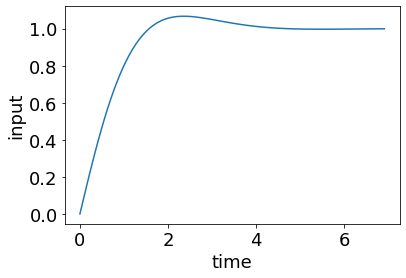

In [86]:
#Solution for 4 b.
import control

a = 1
b = 1

k_i = 2
k_p = 1

A = np.array([[-a+(-a*k_p)/b,k_i/b],[-a,0]])
B = np.array([[k_p/b],[1]])
C = np.array([[a,0]])
D = np.array([[0]])


ss = ctrl.StateSpace(A, B, C, D)
tf = ctrl.ss2tf(ss)
print(tf)
gm, pm, Wcg, Wcp = control.margin(ss)
print(control.margin(ss))
#print(gm)
#print(pm)
#print(hh)
#print(ss)


#ctrl.tf2ss(tf)
t,y = ctrl.step_response(ss)
#t,y = ctrl.impulse_response(tf) # <-- same result

plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('input')

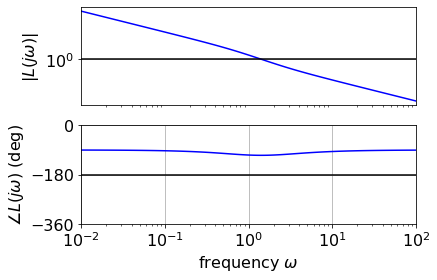

In [87]:
#Possible solution #1 for 4 b.
k_P = 1
k_I = 2.
L = lambda s : ((s*k_P)+k_I) / (s**2+s)
#L = lambda s : s+2
omega = np.logspace(-2,2,100)
xlim = omega[[0,-1]]

abs_L = np.abs(L(1.j*omega))
angle_L = np.unwrap(np.angle(L(1.j*omega)))*180./np.pi

critical = (angle_L < -180).nonzero()[0]

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid('on')
ax.loglog(omega,abs_L,'b-')
ax.loglog(xlim,[1.,1.],'k-')
ax.loglog(omega[critical],abs_L[critical],'ro')
ax.set_ylabel(r'$|L(j\omega)|$')
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.semilogx(omega,angle_L,'b-')
ax.semilogx(xlim,[-180.,-180.],'k-')
ax.semilogx(omega[critical],angle_L[critical],'ro')
ax.set_xlabel(r'frequency $\omega$')
ax.set_ylabel(r'$\angle L(j\omega)$ (deg)')
ax.set_yticks([0,-180,-360])
ax.set_xlim(xlim)
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


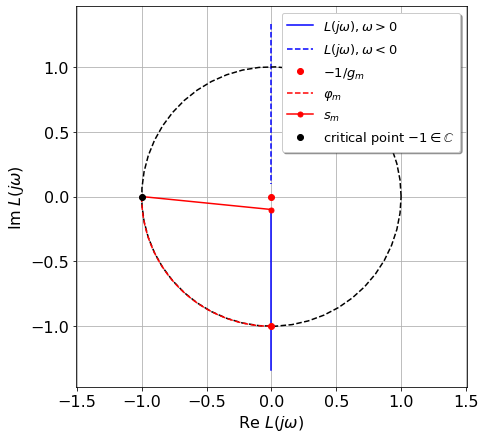

In [69]:
#Possible Solution #2 for 4 b.
k_P = 1
k_I = 1.
L = lambda s : (s*k_P+k_I) / (s**2+s) # (s*k_P +k_I) / (s^2+s)

omega = np.linspace(0.75,1e1,1000)
Omega = L(1.j*omega)

abs_L = np.abs(Omega)
angle_L = np.unwrap(np.angle(Omega))*180./np.pi

circle = np.exp(1.j*np.linspace(0.,2*np.pi))

# index (i.e. entry) of Omega array corresponding to stability margin
g_m_idx = (angle_L < 180).nonzero()[0][0]
phi_m_idx = np.argmin(np.min(np.abs(Omega - circle[:,np.newaxis]),axis=0))
s_m_idx = np.argmin(np.abs(Omega - (-1.)))

# numerical value of stability margin
g_m = -1./Omega[g_m_idx].real
phi_m = np.angle(Omega[phi_m_idx])*180./np.pi
phi_m_arc = np.exp(1.j*np.linspace(-180,phi_m)*np.pi/180.)
s_m = np.abs(Omega[s_m_idx] - (-1.))

axs = []

plt.figure(figsize=(7,7))
ax = plt.subplot(1,1,1); ax.grid('on'); ax.axis('equal')
# Omega, i.e. graph of L(j omega)
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
# unit circle
ax.plot(circle.real,circle.imag,'k--')
# stability margins
ax.plot(-1./g_m,0.,'ro',label=r'$-1/g_m$')
ax.plot(phi_m_arc.real,phi_m_arc.imag,'r--',label=r'$\varphi_m$')
ax.plot(Omega[phi_m_idx].real,Omega[phi_m_idx].imag,'ro')
ax.plot([-1.,Omega[s_m_idx].real],[0.,Omega[s_m_idx].imag],'r.-',ms=10,label=r'$s_m$')
# critical point (-1. + 0.j)
ax.plot(-1.,0.,'ko',label=r'critical point $-1\in\mathbb{C}$')
# legend and labels
ax.legend(fontsize=13,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

(inf, 143.13010235415584, nan, 1.000000000000003)


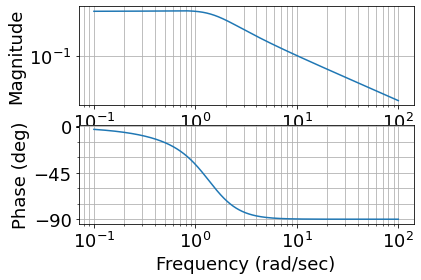

In [58]:
k_P = 1
k_I = 2
num = [k_P, k_I]
den = [1,1+k_P,k_I]

tf = ctrl.TransferFunction(num,den)
ss = ctrl.tf2ss(tf) 
gm, pm, Wcg, Wcp = control.margin(ss)
print(control.margin(ss))
bodee = ctrl.bode_plot(ss);
#ctrl.dcgain(ss)
#ctrl.bode_plot(tf);

In [ ]:

a = 1.
b = 1.


k_P = 5
k_I = 10.

# reference velocity -- can vary over time
r = lambda t : 60. * np.ones_like(t) # miles per hour

# road slope increases at time 5 sec, causing a negative force
# then goes back to zero at 20 sec
v = (lambda t : -10 * (t >= 5.) * (t <= 20.)) # rad

In [ ]:
# differential equation satisfied by car velocity:  \dot{y} = -a y + b (u + v)
def dy(t,y,u): 
  return -a * y + b * (u + v(t))

# differential equation satisfied by proportional-integral controller state
def dz(t,y):
  return r(t) - y

# proportional-integral controller
def u(t,y,z):
  return k_P * (r(t) - y) + k_I * z

# initialize at reference velocity
y0 = r(0.) 

# initialize integrator state to zero
z0 = 0.

# controlled system state consists of car velocity and error integral
x0 = np.asarray([y0,z0])

def f(t,x):
  y,z = x
  return np.asarray([dy(t,y,u(t,y,z)),dz(t,y)])

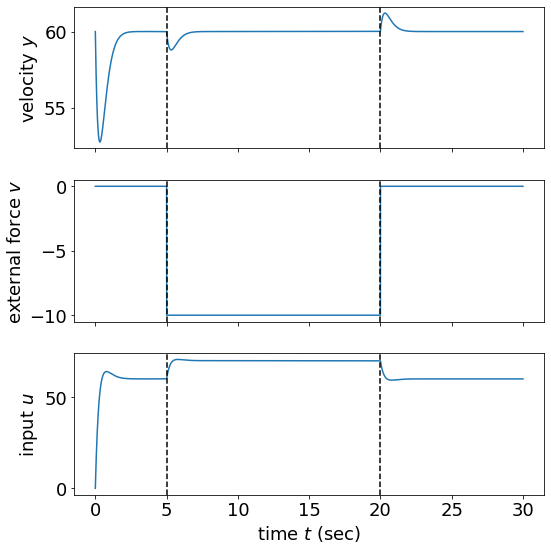

In [ ]:
t = 30. # sec; simulation duration

t_,x_ = numerical_simulation(f,t,x0)

y_,z_ = x_.T

plt.figure(figsize=(8,8))

ax = plt.subplot(3,1,1)
ax.plot(t_,y_)
ylim = ax.get_ylim()
for _ in [5., 20.]:
  ax.plot(_*np.ones(2),ylim,'k--')
#ax.plot(t_,v_r(t_),'k--')
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'velocity $y$')

ax = plt.subplot(3,1,2)
ax.plot(t_,v(t_))
ylim = ax.get_ylim()
for _ in [5., 20.]:
  ax.plot(_*np.ones(2),ylim,'k--')
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'external force $v$')

ax = plt.subplot(3,1,3)
ax.plot(t_,u(t_,y_,z_))
ylim = ax.get_ylim()
for _ in [5., 20.]:
  ax.plot(_*np.ones(2),ylim,'k--')
ax.set_ylim(ylim)
ax.set_ylabel(r'input $u$')

ax.set_xlabel(r'time $t$ (sec)')

plt.tight_layout(); # semicolon suppresses text printout